# Evaluate breakpoint detection simulation
We start by comparing the old version with the new version. On simulated data, the results should not differ too much. On real data, we should be more robust to noise (see notebook "Visualize breakpoint detection on real data").

In [121]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
from scipy.cluster.hierarchy import ward, leaves_list
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

In [142]:
counts = pd.read_csv('/cluster/work/bewi/members/pedrof/sc-dna/notebooks/bp_detection/sim_data/10nodes_40regions_100000reads_9_d_mat.csv', header=None).to_numpy()

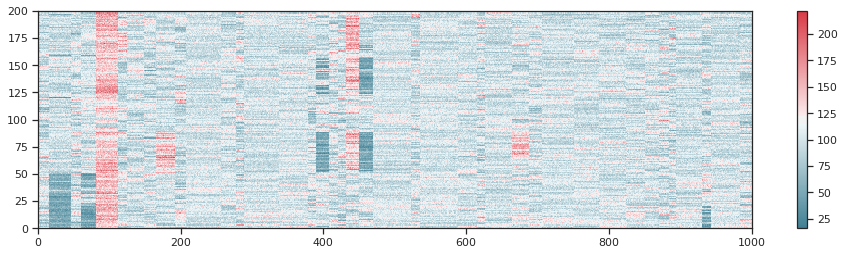

In [124]:
fig = plt.figure(figsize=(16, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
Z = ward(pdist(counts))
hclust_index = leaves_list(Z)
counts = counts[hclust_index]
plt.pcolor(counts, cmap=cmap)
plt.colorbar()
plt.show()

In [143]:
cell_genotypes = pd.read_csv('/cluster/work/bewi/members/pedrof/sc-dna/notebooks/bp_detection/sim_data/10nodes_40regions_100000reads_9_ground_truth.csv', header=None)

In [59]:
cell_bps = cell_genotypes.diff(periods=1, axis=1)
cell_bps = cell_bps.fillna(value=0.0)
cell_bps[cell_bps != 0] = 1 # replace the non-zeroes by 1
cell_bps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
grouped_cell_bps = cell_bps.sum(axis=0)

In [83]:
bps_indicator = np.zeros(grouped_cell_bps.shape[0])
bps_indicator[grouped_cell_bps>=1] = 1

In [84]:
print(f"Number of true breakpoints: {np.sum(bps_indicator==1)}")

Number of true breakpoints: 17


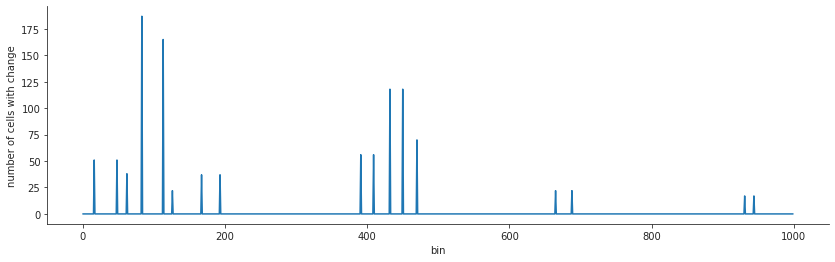

In [49]:
fig = plt.figure(figsize=(14, 4))
plt.plot(grouped_cell_bps)
plt.ylabel('number of cells with change')
plt.xlabel('bin')
sns.despine()
plt.show()

In [138]:
cell_genotypes.shape

(200, 1000)

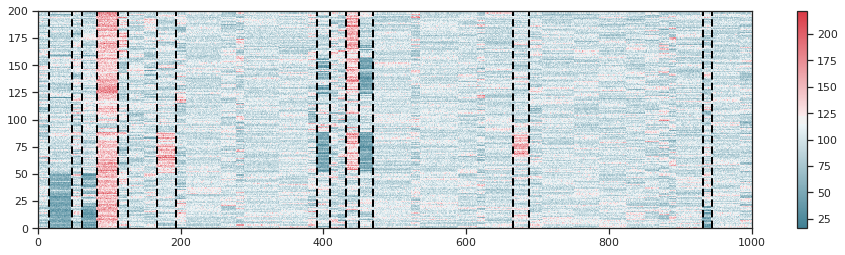

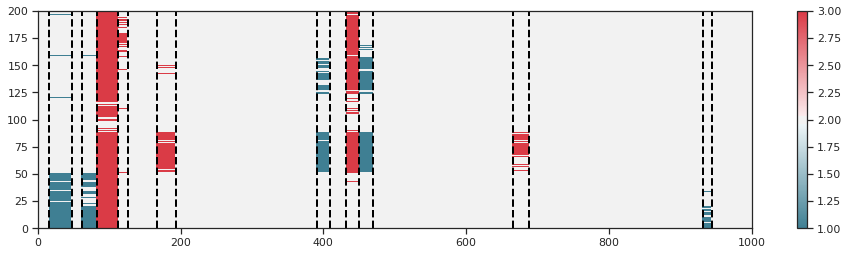

In [144]:
fig = plt.figure(figsize=(16, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
Z = ward(pdist(counts))
hclust_index = leaves_list(Z)
counts = counts[hclust_index]
plt.pcolor(counts, cmap=cmap)
plt.colorbar()
ax = plt.gca()
ax.vlines(np.where(bps_indicator)[0], *ax.get_ylim(), colors='black', linestyles='dashed', linewidths=2)
plt.show()

fig = plt.figure(figsize=(16, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cell_genotypes = cell_genotypes.to_numpy()
cell_genotypes = cell_genotypes[hclust_index]
plt.pcolor(cell_genotypes, cmap=cmap)
plt.colorbar()
ax = plt.gca()
ax.vlines(np.where(bps_indicator)[0], *ax.get_ylim(), colors='black', linestyles='dashed', linewidths=2)
plt.show()

In [132]:
np.where(bps_indicator)

(array([ 16,  48,  62,  83, 113, 126, 167, 193, 391, 409, 432, 450, 470,
        665, 688, 931, 944]),)

## New version

In [171]:
sp_vec = pd.read_csv('/cluster/work/bewi/members/pedrof/sc-dna/notebooks/bp_detection/sim_data/_sp_vec.csv', header=None).to_numpy().ravel()

In [172]:
sp_vec.shape

(1000,)

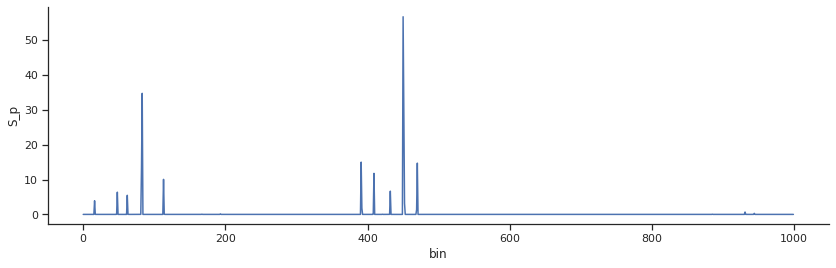

In [173]:
fig = plt.figure(figsize=(14, 4))
plt.plot(sp_vec)
plt.ylabel('S_p')
plt.xlabel('bin')
# plt.yscale('log')
sns.despine()
plt.show()

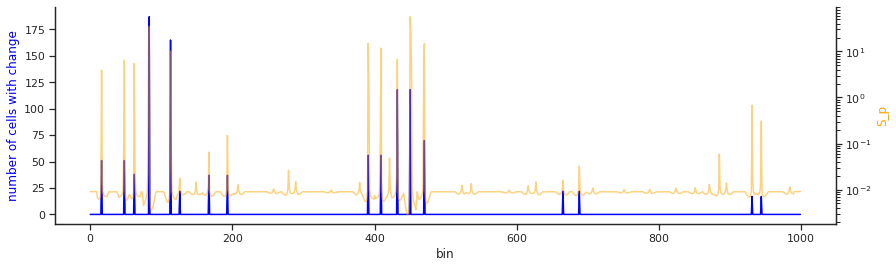

In [174]:
fig, ax1 = plt.subplots(figsize=(14, 4))

ax2 = ax1.twinx()
ax1.plot(grouped_cell_bps, color='blue', alpha=1)
ax2.plot(sp_vec, color="orange", alpha=0.5)

ax1.set_xlabel('bin')
ax1.set_ylabel('number of cells with change', color='blue')
ax2.set_ylabel('S_p', color='orange')
ax2.set_yscale('log')
sns.despine(right=False)
plt.show()

In [175]:
inferred_bps = pd.read_csv('/cluster/work/bewi/members/pedrof/sc-dna/notebooks/bp_detection/sim_data/_all_bps_comparison.csv', header=None)
inferred_bps.columns = ['idx','log_sp','third_q']

In [176]:
inferred_bps_indicator = np.zeros(sp_vec.ravel().shape[0])
inferred_bps_indicator[inferred_bps.idx] = 1.

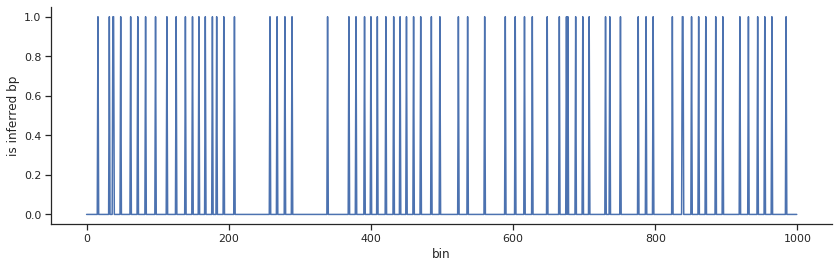

In [177]:
fig = plt.figure(figsize=(14, 4))
plt.plot(inferred_bps_indicator)
plt.ylabel('is inferred bp')
plt.xlabel('bin')
sns.despine()
plt.show()

In [178]:
# Quantitative evaluation
print(bps_indicator.sum(), inferred_bps_indicator.sum())

tpr = np.count_nonzero(inferred_bps_indicator[np.where(bps_indicator==1)[0]]==1) / np.count_nonzero(bps_indicator==1)
tnr = np.count_nonzero(inferred_bps_indicator[np.where(bps_indicator==0)[0]]==0) / np.count_nonzero(bps_indicator==0)

fpr = np.count_nonzero(inferred_bps_indicator[np.where(bps_indicator==0)[0]]==1) / np.count_nonzero(inferred_bps_indicator==1)
fnr = np.count_nonzero(inferred_bps_indicator[np.where(bps_indicator==1)[0]]==0) / np.count_nonzero(inferred_bps_indicator==0)

print(tpr, tnr, fpr, fnr)

17.0 71.0
1.0 0.9450661241098678 0.7605633802816901 0.0


## Old version

In [157]:
sp_vec_old = pd.read_csv('/cluster/work/bewi/members/pedrof/sc-dna/notebooks/bp_detection/sim_data/old_sp_vec.csv', header=None).to_numpy().ravel()

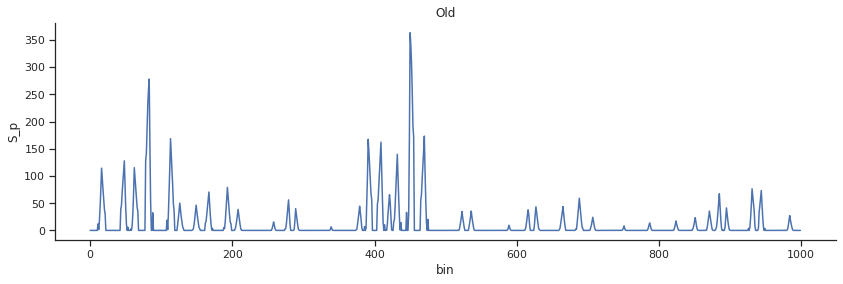

In [158]:
fig = plt.figure(figsize=(14, 4))
plt.plot(sp_vec_old)
plt.ylabel('S_p')
plt.xlabel('bin')
# plt.yscale('log')
plt.title('Old')
sns.despine()
plt.show()

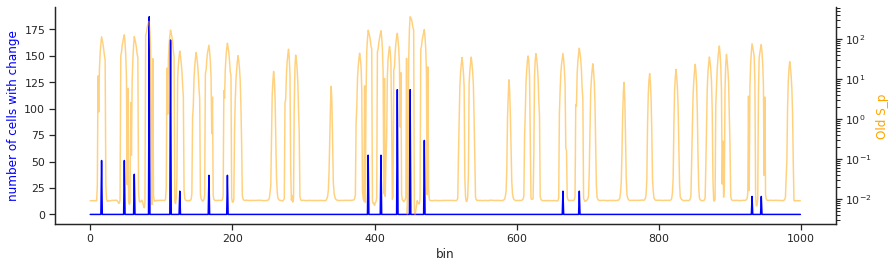

In [159]:
fig, ax1 = plt.subplots(figsize=(14, 4))

ax2 = ax1.twinx()
ax1.plot(grouped_cell_bps, color='blue', alpha=1)
ax2.plot(sp_vec_old, color="orange", alpha=0.5)

ax1.set_xlabel('bin')
ax1.set_ylabel('number of cells with change', color='blue')
ax2.set_ylabel('Old S_p', color='orange')
ax2.set_yscale('log')
sns.despine(right=False)
plt.show()

In [161]:
inferred_bps_old = pd.read_csv('/cluster/work/bewi/members/pedrof/sc-dna/notebooks/bp_detection/sim_data/old_all_bps_comparison.csv', header=None)
inferred_bps_old.columns = ['idx','log_sp','stdev']

In [162]:
inferred_bps_indicator_old = np.zeros(sp_vec_old.ravel().shape[0])
inferred_bps_indicator_old[inferred_bps_old.idx] = 1.

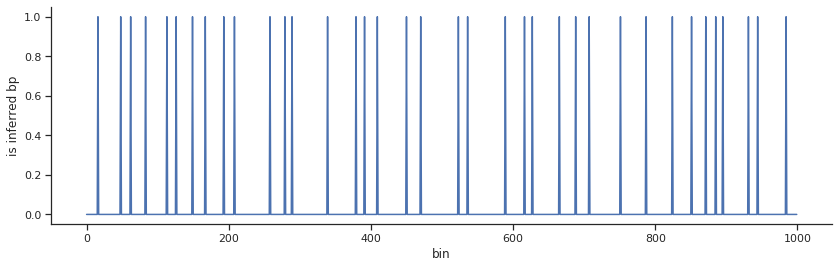

In [163]:
fig = plt.figure(figsize=(14, 4))
plt.plot(inferred_bps_indicator_old)
plt.ylabel('is inferred bp')
plt.xlabel('bin')
sns.despine()
plt.show()

In [164]:
# Quantitative evaluation
print(bps_indicator.sum(), inferred_bps_indicator_old.sum())

tpr = np.count_nonzero(inferred_bps_indicator_old[np.where(bps_indicator==1)[0]]==1) / np.count_nonzero(bps_indicator==1)
tnr = np.count_nonzero(inferred_bps_indicator_old[np.where(bps_indicator==0)[0]]==0) / np.count_nonzero(bps_indicator==0)

fpr = np.count_nonzero(inferred_bps_indicator_old[np.where(bps_indicator==0)[0]]==1) / np.count_nonzero(inferred_bps_indicator_old==1)
fnr = np.count_nonzero(inferred_bps_indicator_old[np.where(bps_indicator==1)[0]]==0) / np.count_nonzero(inferred_bps_indicator_old==0)

print(tpr, tnr, fpr, fnr)

17.0 37.0
0.9411764705882353 0.9786368260427264 0.5675675675675675 0.0010384215991692627


## Overlay both versions

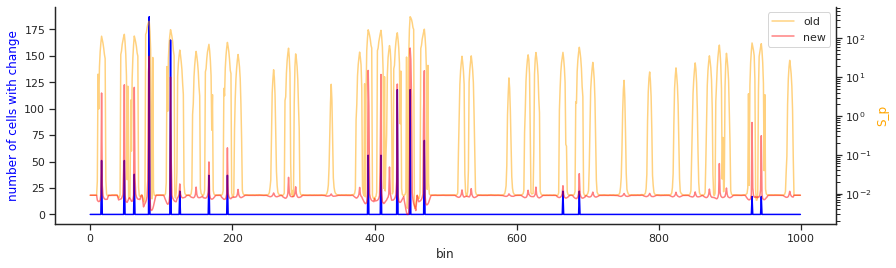

In [155]:
fig, ax1 = plt.subplots(figsize=(14, 4))

ax2 = ax1.twinx()
ax1.plot(grouped_cell_bps, color='blue', alpha=1)
ax2.plot(sp_vec_old, color="orange", alpha=0.5, label='old')
ax2.plot(sp_vec, color="red", alpha=0.5, label='new')

ax1.set_xlabel('bin')
ax1.set_ylabel('number of cells with change', color='blue')
ax2.set_ylabel('S_p', color='orange')
ax2.set_yscale('log')
sns.despine(right=False)
plt.legend()
plt.show()